In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = North Dakota
state_ab = "nd"

## Data
1. Download all the data in directory "tn_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
send_data = "./{}{}_sldu_adopted_2021/nd_sldu_adopted_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/FinalShape1282021 2021-12-08.shp".format(data_folder, state_ab)

In [5]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    if maup.doctor(df):
        print('smart_repair successful')
            
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        raise Exception('smart_repair failed')
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)
    
    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")
    
    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]
    
    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col):    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)

    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated

    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    
    # check if population agrees
    check_population(population, df)
        
    return df

### Read the census data

In [11]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [12]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [13]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [14]:
maup.doctor(population_df)

100%|██████████| 84566/84566 [01:43<00:00, 814.91it/s] 


True

In [15]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

## Read the vest 20 data

Now using it as a "base pricinct"

In [18]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [19]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████| 422/422 [00:01<00:00, 342.04it/s]


In [20]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREOWRI', 'G20HALRARM', 'G20HALDRAK', 'G20HALLPET',
       'G20HALOWRI', 'G20GOVRBUR', 'G20GOVDLEN', 'G20GOVLHEN', 'G20GOVOWRI',
       'G20AUDRGAL', 'G20AUDDHAR', 'G20AUDOWRI', 'G20TRERBEA', 'G20TREDHAU',
       'G20TREOWRI', 'G20INSRGOD', 'G20INSOWRI', 'G20PSCRKRO', 'G20PSCDBUC',
       'G20PSCOWRI', 'geometry'],
      dtype='object')

In [21]:
start_col = 3
vest_base_data = vest20
year = '20'

In [22]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [23]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████| 422/422 [00:00<00:00, 1288.16it/s]


In [24]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [25]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [26]:
election_df.columns

Index(['AUD20D', 'AUD20O', 'AUD20R', 'COUNTYFP', 'GOV20D', 'GOV20O', 'GOV20R',
       'HAL20D', 'HAL20O', 'HAL20R', 'INS20O', 'INS20R', 'PRE20D', 'PRE20O',
       'PRE20R', 'PRECINCT', 'PSC20D', 'PSC20O', 'PSC20R', 'STATEFP', 'TRE20D',
       'TRE20O', 'TRE20R', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [27]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,779094,779094,True
HISP,HISP,33412,33412,True
NH_WHITE,NH_WHITE,636160,636160,True
NH_BLACK,NH_BLACK,26152,26152,True
NH_AMIN,NH_AMIN,37350,37350,True
NH_ASIAN,NH_ASIAN,13050,13050,True
NH_NHPI,NH_NHPI,869,869,True
NH_OTHER,NH_OTHER,1853,1853,True
NH_2MORE,NH_2MORE,30248,30248,True
H_WHITE,H_WHITE,9778,9778,True


## Add more vest data

In [28]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [29]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G18USSRCRA', 'G18USSDHEI',
       'G18USSOWRI', 'G18HALRARM', 'G18HALDSCH', 'G18HALITUT', 'G18HALOWRI',
       'G18SOSDBOS', 'G18SOSICOA', 'G18SOSIJAE', 'G18SOSOWRI', 'G18ATGRSTE',
       'G18ATGDTHO', 'G18ATGOWRI', 'G18AGRRGOE', 'G18AGRDDOT', 'G18AGROWRI',
       'G18PSCRCHR', 'G18PSCDBRA', 'G18PSCOWRI', 'G18PSCRKRO', 'G18PSCDBUC',
       'G18PSCOWR2', 'G18TAXRRAU', 'G18TAXDOVE', 'G18TAXOWRI', 'geometry'],
      dtype='object')

In [30]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PRECCAS', 'G16PREOFUE', 'G16PREOWRI',
       'G16USSRHOE', 'G16USSDGLA', 'G16USSLMAR', 'G16USSIGER', 'G16USSOWRI',
       'G16HALRCRA', 'G16HALDIRO', 'G16HALLSEA', 'G16HALOWRI', 'G16GOVRBUR',
       'G16GOVDNEL', 'G16GOVLRIS', 'G16GOVOWRI', 'G16AUDRGAL', 'G16AUDLRIE',
       'G16AUDOWRI', 'G16TRERSCH', 'G16TREDMAT', 'G16TRELOLS', 'G16TREOWRI',
       'G16INSRGOD', 'G16INSDBUF', 'G16INSLBAT', 'G16INSOWRI', 'G16PSCRFED',
       'G16PSCDHUN', 'G16PSCLSKA', 'G16PSCOWRI', 'geometry'],
      dtype='object')

In [31]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████| 424/424 [00:01<00:00, 345.95it/s]


There are 8 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 541/541 [00:00<00:00, 1453.07it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|██████████| 424/424 [00:01<00:00, 366.35it/s]


smart_repair successful


100%|██████████| 422/422 [00:00<00:00, 1146.74it/s]


population agrees


In [32]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'AUD20D', 'AUD20O', 'AUD20R', 'BVAP',
       'COUNTYFP', 'GOV20D', 'GOV20O', 'GOV20R', 'HAL18D', 'HAL18O', 'HAL18R',
       'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'INS20O',
       'INS20R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK',
       'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O',
       'PRE20R', 'PRECINCT', 'PSC18D', 'PSC18O', 'PSC18R', 'PSC20D', 'PSC20O',
       'PSC20R', 'SOS18D', 'SOS18O', 'STATEFP', 'TAX18D', 'TAX18O', 'TAX18R',
       'TOTPOP', 'TRE20D', 'TRE20O', 'TRE20R', 'USS18D', 'USS18O', 'USS18R',
       'VAP', 'WVAP', 'geometry'],
      dtype='object')

In [33]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████| 432/432 [00:01<00:00, 322.91it/s]


There are 3 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 547/547 [00:00<00:00, 1026.96it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|██████████| 432/432 [00:01<00:00, 372.34it/s]


smart_repair successful


100%|██████████| 422/422 [00:00<00:00, 1364.11it/s]


population agrees


##  Add the district data

In [34]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [35]:
send.head()

,DISTRICT,geometry
0,1,"POLYGON ((-103.60498 48.16885, -103.60476 48.1..."
1,10,"POLYGON ((-96.88305 46.82944, -96.88313 46.831..."
2,11,"POLYGON ((-96.83015 46.86149, -96.82749 46.861..."
3,12,"POLYGON ((-98.62722 47.32655, -98.62692 47.326..."
4,13,"POLYGON ((-96.96862 46.87973, -96.96864 46.880..."


In [36]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████| 47/47 [00:00<00:00, 151.86it/s]


There are 2 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 49/49 [00:00<00:00, 696.10it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████| 47/47 [00:00<00:00, 128.06it/s]


smart_repair successful


100%|██████████| 47/47 [00:01<00:00, 36.21it/s]


In [37]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,F_DEVIATIO,DISTRICT_L,geometry
0,1,16.044886,1,1.0,None,None,15976,16576.0,-600.0,-0.036197,1|-3.62%,"POLYGON ((-103.60498 48.16885, -103.60476 48.1..."
1,2,4.740046,10,1.0,None,None,16660,16576.0,84.0,0.005068,10|0.51%,"POLYGON ((-96.88305 46.82944, -96.88313 46.831..."
2,3,3.423964,11,1.0,None,None,16529,16576.0,-47.0,-0.002835,11|-0.28%,"POLYGON ((-96.83015 46.86149, -96.82749 46.861..."
3,4,405.199005,12,1.0,None,None,15845,16576.0,-731.0,-0.044100,12|-4.41%,"POLYGON ((-98.62722 47.32655, -98.62692 47.326..."
4,5,7.899739,13,1.0,None,None,16790,16576.0,214.0,0.012910,13|1.29%,"POLYGON ((-96.96862 46.87973, -96.96864 46.880..."


In [38]:
hdist = hdist.to_crs("EPSG:4269")
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|██████████| 49/49 [00:00<00:00, 137.19it/s]


There are 2 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 51/51 [00:00<00:00, 806.55it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████| 49/49 [00:00<00:00, 200.99it/s]


smart_repair successful


100%|██████████| 49/49 [00:01<00:00, 41.24it/s]


In [39]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'AUD16O', 'AUD16R', 'AUD20D', 'AUD20O',
       'AUD20R', 'BVAP', 'COUNTYFP', 'GOV16D', 'GOV16O', 'GOV16R', 'GOV20D',
       'GOV20O', 'GOV20R', 'HAL16D', 'HAL16O', 'HAL16R', 'HAL18D', 'HAL18O',
       'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'INS16D', 'INS16O', 'INS16R', 'INS20O', 'INS20R', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT', 'PSC16D', 'PSC16O', 'PSC16R', 'PSC18D', 'PSC18O', 'PSC18R',
       'PSC20D', 'PSC20O', 'PSC20R', 'SOS18D', 'SOS18O', 'STATEFP', 'TAX18D',
       'TAX18O', 'TAX18R', 'TOTPOP', 'TRE16D', 'TRE16O', 'TRE16R', 'TRE20D',
       'TRE20O', 'TRE20R', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18O',
     

### Put the base precinct year after the precinct information column

In [40]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'PRECINCT':'PRECINCT'+year}
election_df.rename(columns=base_columns, inplace = True)

In [41]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'AUD16O', 'AUD16R', 'AUD20D', 'AUD20O',
       'AUD20R', 'BVAP', 'COUNTYFP20', 'GOV16D', 'GOV16O', 'GOV16R', 'GOV20D',
       'GOV20O', 'GOV20R', 'HAL16D', 'HAL16O', 'HAL16R', 'HAL18D', 'HAL18O',
       'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'INS16D', 'INS16O', 'INS16R', 'INS20O', 'INS20R', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT20', 'PSC16D', 'PSC16O', 'PSC16R', 'PSC18D', 'PSC18O',
       'PSC18R', 'PSC20D', 'PSC20O', 'PSC20R', 'SOS18D', 'SOS18O', 'STATEFP20',
       'TAX18D', 'TAX18O', 'TAX18R', 'TOTPOP', 'TRE16D', 'TRE16O', 'TRE16R',
       'TRE20D', 'TRE20O', 'TRE20R', 'USS16D', 'USS16O', 'USS16R', 'USS18D',
       'U

In [42]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'PRECINCT'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [43]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

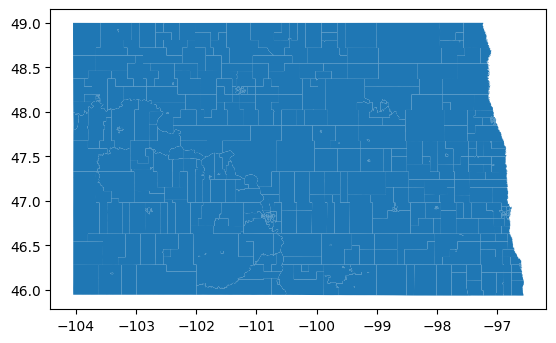

In [44]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()